In [1]:
import os 
import cv2
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as ans 
from tqdm import tqdm 
import shutil 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model
from tensorflow.keras import layers 
from datetime import datetime
from tensorflow.keras.layers import Dense, Input, UpSampling2D, Conv2DTranspose, Conv2D,\
    Lambda, Concatenate, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Add, LayerNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMG_DIMS = (256, 256, 3)
IMG_WIDTH = IMG_HEIGHT = 256 
CHANNELS = 3
BATCH = 16
RESIZE_HEIGHT = 286 
RESIZE_WIDTH = 286
LAMBDA = 100

In [3]:
url = 'https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/releases/download/facades/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=url,
                                      extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'facades/')

## **Augmentation and preprocessing functions**

In [5]:
# sem_image ---> semantic segmenration image
# non_sem_image ---> real photo.

def load(image_path): 
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw) 
    image = tf.cast(image, tf.float32)
    width_cutoff = IMG_WIDTH
    non_sem_image = image[:, :width_cutoff]
    sem_image = image[:, width_cutoff:]
    
    return sem_image, non_sem_image


def resize(sem_image, non_sem_image, height, width):
    sem_image = tf.image.resize(sem_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    non_sem_image = tf.image.resize(non_sem_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return sem_image, non_sem_image


def random_crop(sem_image, non_sem_image):
    stacked_image = tf.stack([sem_image, non_sem_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


def random_jitter(sem_image, non_sem_image):
    if tf.random.uniform(()) > 0.5:
    # Random mirroring
        sem_image = tf.image.flip_left_right(sem_image)
        non_sem_image = tf.image.flip_left_right(non_sem_image)

    return sem_image, non_sem_image


def normalize(sem_image, non_sem_image):
    sem_image = (sem_image / 127.5) - 1
    non_sem_image = (non_sem_image / 127.5) - 1

    return sem_image, non_sem_image

In [97]:
path

'/root/.keras/datasets/facades/'

## **Augmentation Pipeline**

In [6]:
def augmentation(sem_image, non_sem_image, is_normalize=False): 
    sem_image, non_sem_image = resize(sem_image, non_sem_image, RESIZE_HEIGHT, RESIZE_WIDTH)
    sem_image, non_sem_image = random_crop(sem_image, non_sem_image)
    sem_image, non_sem_image = random_jitter(sem_image, non_sem_image)
    sem_image = tf.cast(sem_image, tf.float32)
    non_sem_image = tf.cast(non_sem_image, tf.float32)
    if is_normalize:
        sem_image, non_sem_image = normalize(sem_image, non_sem_image)
    
    return sem_image, non_sem_image

## Visualize seg and non-seg image

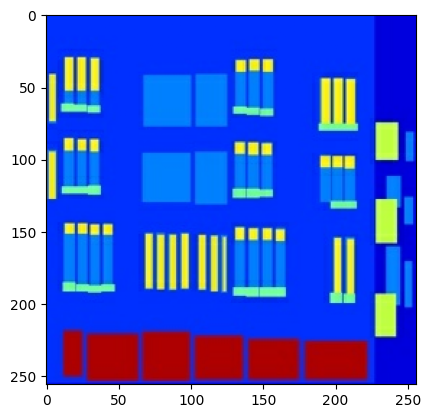

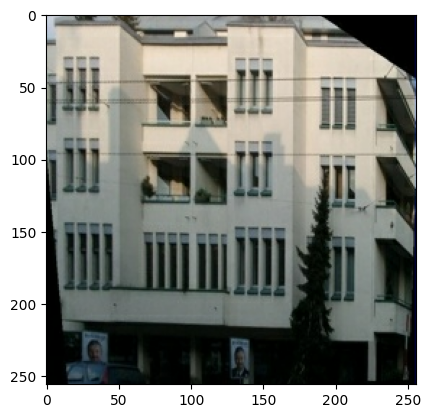

In [7]:
sem_image, non_sem_image = load(path + "train/" + "1.jpg")
plt.figure()
plt.imshow(sem_image / 255.0)
plt.figure()
plt.imshow(non_sem_image / 255.0)

## **Visualize Preprocessed images**

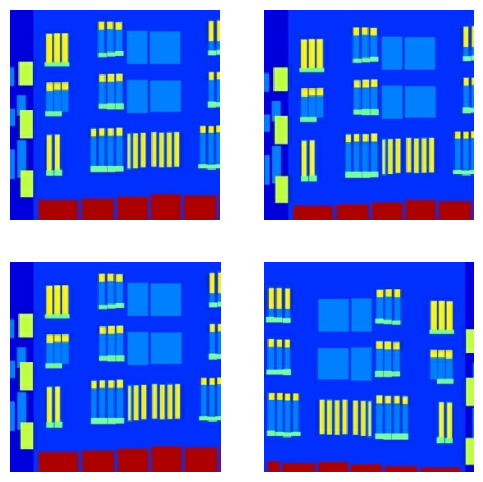

In [8]:
plt.figure(figsize=(6, 6))
for i in range(4):
    aug_sem, aug_non_sem = augmentation(sem_image, non_sem_image)
    plt.subplot(2, 2, i + 1)
    plt.imshow(aug_sem / 255.0)
    plt.axis('off')
plt.show()

In [9]:
def preprocess_train_data(img_path):
    sem_image, non_sem_image = load(img_path)
    sem_image, non_sem_image = augmentation(sem_image, non_sem_image, is_normalize=True)
    
    return sem_image, non_sem_image

def preprocess_test_data(img_path):
    sem_image, non_sem_image = load(img_path)
    sem_image, non_sem_image = resize(sem_image, non_sem_image, IMG_HEIGHT, IMG_WIDTH)
    sem_image, non_sem_image = normalize(sem_image, non_sem_image)
    
    return sem_image, non_sem_image

In [10]:
train_ds = tf.data.Dataset.list_files(str(path + 'train/*.jpg'))
train_ds = (train_ds.shuffle(100)
                    .map(preprocess_train_data, tf.data.AUTOTUNE)
                    .batch(BATCH, drop_remainder=True)
                    .prefetch(tf.data.AUTOTUNE))

In [11]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None))>

In [12]:
test_ds = tf.data.Dataset.list_files(str(path + 'test/*.jpg'))
test_ds = (test_ds.shuffle(100)
                    .map(preprocess_test_data, tf.data.AUTOTUNE)
                    .batch(BATCH, drop_remainder=True)
                    .prefetch(tf.data.AUTOTUNE))

In [13]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, None), dtype=tf.float32, name=None))>

## **Generator (UNET)**

In [14]:
def downsampler(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # sequential layer
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    # whether to apply batchnorm or not
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [15]:
def upsampler(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            use_bias=False)
                                        )
    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [16]:
def get_generator(): 
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    
    # downsmaling using downsmapler (using encoder)
    downsample1 = downsampler(64, 4, apply_batchnorm=False)(inputs) # 128
    downsample2 = downsampler(128, 4)(downsample1) # 64
    downsample3 = downsampler(256, 4)(downsample2) # 32
    downsample4 = downsampler(512, 4)(downsample3) # 16
    downsample5 = downsampler(512, 4)(downsample4) # 8
    downsample6 = downsampler(512, 4)(downsample5) # 4
    downsample7 = downsampler(512, 4)(downsample6) # 2
    downsample8 = downsampler(512, 4)(downsample7) # 1
    
    # upsampling (decoder)
    upsample1 = upsampler(512, 4, apply_dropout=True)(downsample8) # 2*2
    concat1 = layers.Concatenate()([upsample1, downsample7])   
    
    upsample2 = upsampler(512, 4, apply_dropout=True)(concat1) # 4*4
    concat2 = layers.Concatenate()([upsample2, downsample6])  
    
    upsample3 = upsampler(512, 4, apply_dropout=True)(concat2)  # 8*8
    concat3 = layers.Concatenate()([upsample3, downsample5])  
    
    upsample4 = upsampler(512, 4)(concat3)  # 16 * 16
    concat4 = layers.Concatenate()([upsample4, downsample4]) 
    
    upsample5 = upsampler(256, 4)(concat4)  # 32 * 32
    concat5 = layers.Concatenate()([upsample5, downsample3]) 
    
    upsample6 = upsampler(128, 4)(concat5)   # 64 * 64
    concat6 = layers.Concatenate()([upsample6, downsample2]) 
    
    upsample7 = upsampler(64, 4)(concat6)   # 128 * 128
    concat7 = layers.Concatenate()([upsample7, downsample1]) 
    
    initializer = tf.random_normal_initializer(0., 0.02)
    outputs = tf.keras.layers.Conv2DTranspose(CHANNELS, 4,
                                                 strides=2,
                                                 padding='same',
                                                 kernel_initializer=initializer,
                                                 activation='tanh'
                                          )(concat7)  # (256, 256, 3)
    
    return Model(inputs, outputs)

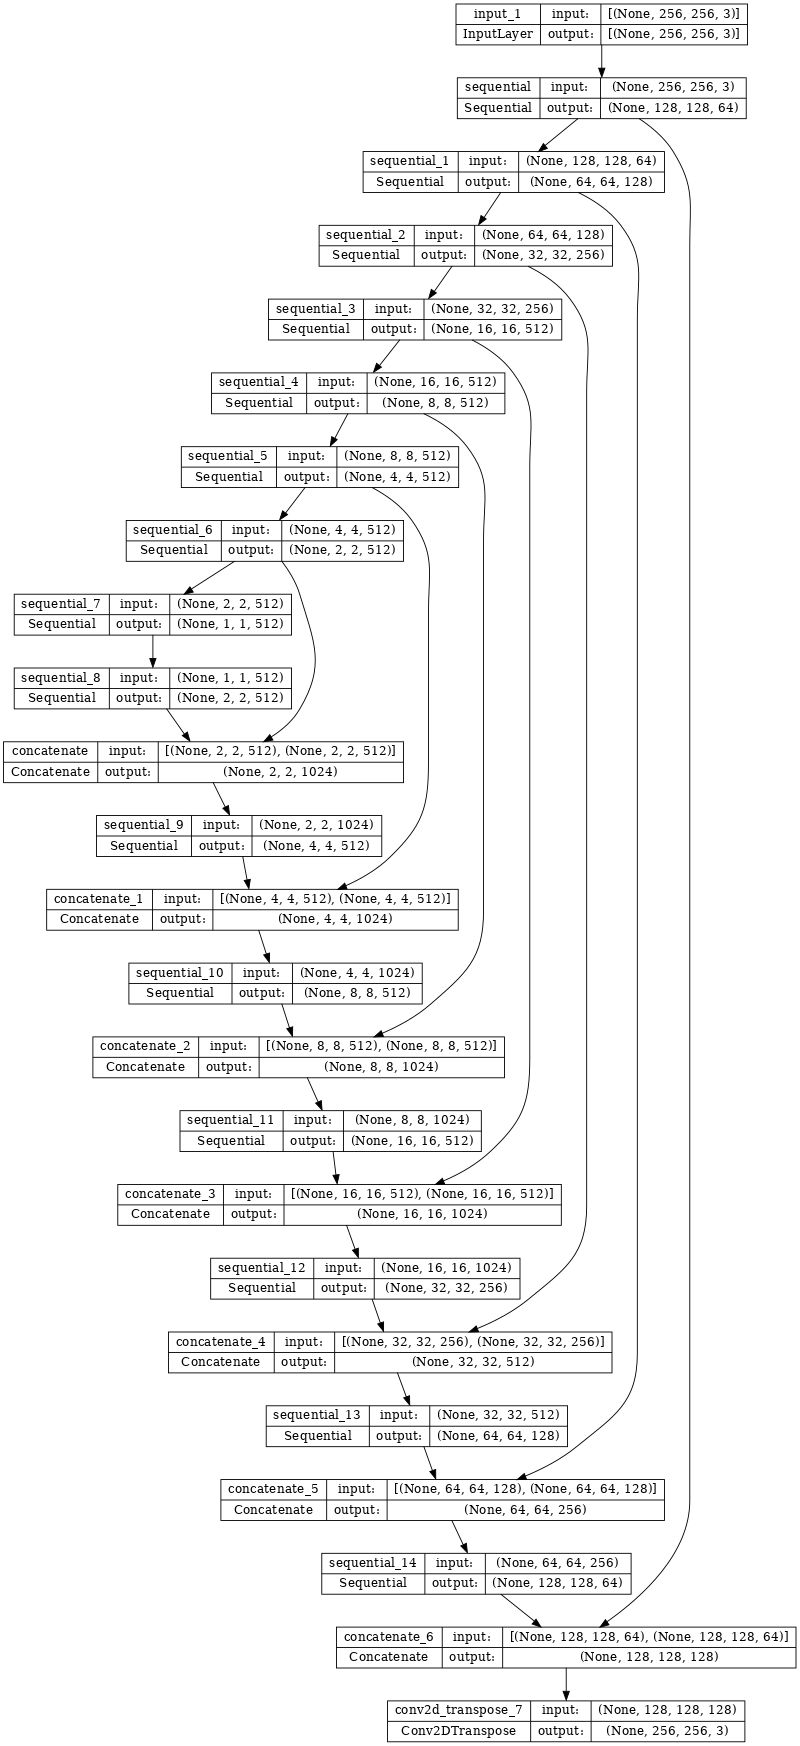

In [17]:
generator = get_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

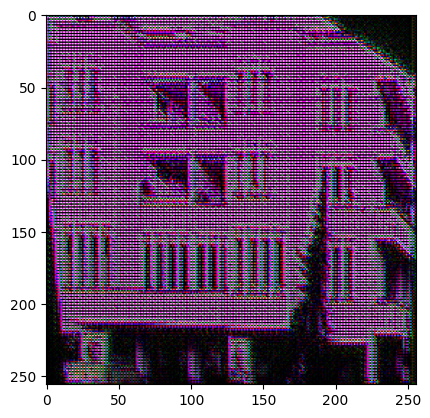

In [18]:
output = generator(tf.reshape(non_sem_image, (1, 256, 256, 3)))
plt.imshow(tf.reshape(output, (256, 256, 3)))

In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## **Discriminator**

In [20]:
def get_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    input_ = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    target = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([input_, target]) 

    down1 = downsampler(64, 4, False)(x)  
    down2 = downsampler(128, 4)(down1) 
    down3 = downsampler(256, 4)(down2) 

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  

    return tf.keras.Model(inputs=[input_, target], outputs=last)

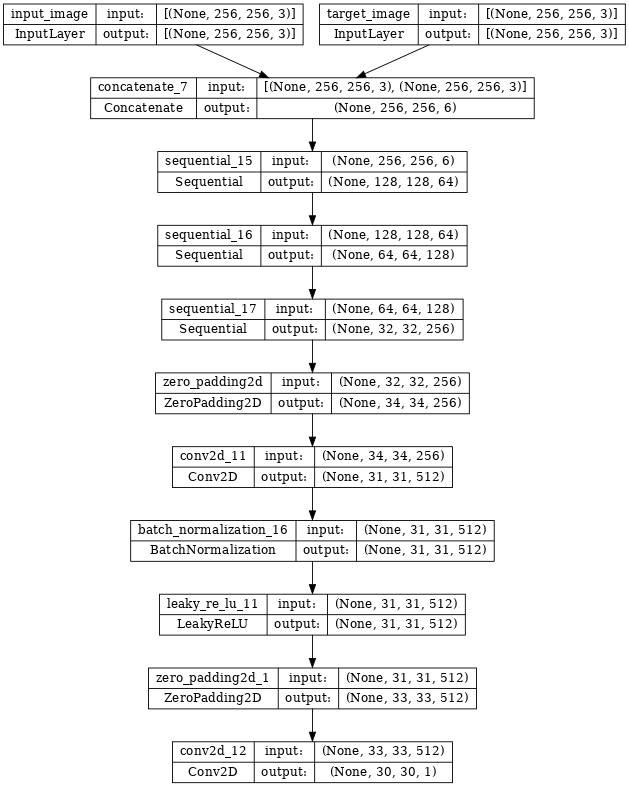

In [21]:
discriminator = get_discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

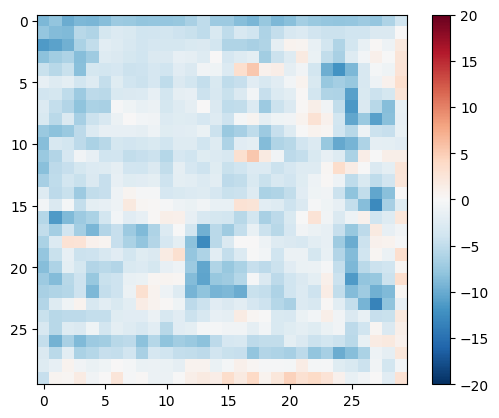

In [22]:
disc_out = discriminator([sem_image[tf.newaxis, ...], output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [23]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [135]:
class PixPixModel(Model): 
    def __init__(self, generator, discriminator):
        super(PixPixModel, self).__init__()
        self.discriminator_loss_tracker = tf.keras.metrics.Mean()
        self.generator_loss_tracker = tf.keras.metrics.Mean()
        
        self.generator_model = generator
        self.discriminator_model = discriminator
        
        self.summary_writer = tf.summary.create_file_writer(
        "logs/" + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    @property
    def metrics(self):
        pass 
    
    def compile(self, disc_optimizer, gen_optimizer):
        super().compile()
        self.discriminator_optimizer = disc_optimizer
        self.generator_optimizer = gen_optimizer
    
    def train_step(self, inputs, step):
        sem_img, non_sem_img = inputs
        
        with tf.GradientTape() as dis_tape, tf.GradientTape() as gen_tape:
            # generating fake image
            generator_output = self.generator_model(sem_img, training=True)
            # classifiying the real and fake images
            dis_real_img_output = self.discriminator_model((sem_img, non_sem_img), training=True)
            dis_fake_img_output = self.discriminator_model((sem_img, generator_output), training=True)
        
            total_gen_loss, gan_loss, l1_loss = self.compute_gen_loss(dis_fake_img_output, non_sem_img, generator_output)
            total_disc_loss = self.compute_dis_loss(dis_real_img_output, dis_fake_img_output)
        
        dis_params = self.discriminator_model.trainable_weights
        gen_params = self.generator_model.trainable_weights
        
        dis_grads = dis_tape.gradient(total_disc_loss, dis_params)
        gen_grads = gen_tape.gradient(total_gen_loss, gen_params)
        
        self.discriminator_optimizer.apply_gradients(zip(dis_grads, dis_params))
        self.generator_optimizer.apply_gradients(zip(gen_grads, gen_params))
        
        self.generator_loss_tracker.update_state(total_gen_loss)
        self.discriminator_loss_tracker.update_state(total_disc_loss)

        #with self.summary_writer.as_default():
        #tf.summary.scalar('gen_total_loss', total_gen_loss, step=step//1000)
        #tf.summary.scalar('gen_gan_loss', gan_loss, step=step//1000)
        #tf.summary.scalar('gen_l1_loss', l1_loss, step=step//1000)
        #tf.summary.scalar('disc_loss', total_disc_loss, step=step//1000)
        return {"gen_loss": self.generator_loss_tracker.result(), "disc_loss": self.discriminator_loss_tracker.result()}
    
    def test_step(self):
        pass
    
    def compute_dis_loss(self, real_img_output, fake_img_output):
        # fake image  output by the discrimnator
        loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # real image loss (30 * 30 * 3)
        real_loss = loss_object(tf.ones_like(real_img_output), real_img_output)
        # real image loss (30 * 30 * 3)
        fake_loss = loss_object(tf.zeros_like(fake_img_output), fake_img_output)
        total_loss = real_loss + fake_loss
        
        return total_loss
    
    def compute_gen_loss(self, fake_img_output, target, gen_output):
        # fake image  output by the discrimnator
        loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # Gan loss
        gan_loss = loss_object(tf.ones_like(fake_img_output), fake_img_output)
        # Mean squared error between the target image and generated image.
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        # total loss
        total_gen_loss = gan_loss + (LAMBDA * l1_loss)
        return total_gen_loss, gan_loss, l1_loss
    
    def call(self, inputs):
        X, y = inputs 
        gen_output = self.generator_model(X)
        return gen_output

In [136]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [137]:
generator_model = get_generator()
discriminator_model = get_discriminator()
model = PixPixModel(generator_model, discriminator_model)
model.compile(discriminator_optimizer, generator_optimizer)

In [138]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

In [139]:
def train(model, train_ds, test_ds, epochs):
    gen_loss_list = []
    disc_loss_list = []
    for epoch in range(epochs):
        for step, train_data_batch in tqdm(enumerate(train_ds), total=len(train_ds)):
            l_step = True if step==len(train_ds)-1 else False
            res = model.train_step(train_data_batch, l_step)
            gen_loss = res.get("gen_loss")
            disc_loss = res.get("disc_loss")
            
        if (epoch) % 20 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)
        print(f"Epochs: {epoch}, Generator_loss: {gen_loss}, Discriminator_loss: {disc_loss}")
    return model

In [140]:
train(model, train_ds, None, 100)

100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Epochs: 0, Generator_loss: 36.701419830322266, Discriminator_loss: 1.5452159643173218


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 1, Generator_loss: 35.68800735473633, Discriminator_loss: 1.3400750160217285


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 2, Generator_loss: 35.37839126586914, Discriminator_loss: 1.2355084419250488


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 3, Generator_loss: 35.23488235473633, Discriminator_loss: 1.1207045316696167


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 4, Generator_loss: 35.18661117553711, Discriminator_loss: 1.041752815246582


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 5, Generator_loss: 35.1041374206543, Discriminator_loss: 1.0049235820770264


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 6, Generator_loss: 35.09787368774414, Discriminator_loss: 0.9497848749160767


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 7, Generator_loss: 35.0523796081543, Discriminator_loss: 0.9020299315452576


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 8, Generator_loss: 35.03666305541992, Discriminator_loss: 0.8722944855690002


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 9, Generator_loss: 35.043731689453125, Discriminator_loss: 0.8255257606506348


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Epochs: 10, Generator_loss: 35.085723876953125, Discriminator_loss: 0.8035982847213745


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 11, Generator_loss: 35.04242706298828, Discriminator_loss: 0.7900805473327637


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 12, Generator_loss: 35.022705078125, Discriminator_loss: 0.7689113020896912


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 13, Generator_loss: 35.03538131713867, Discriminator_loss: 0.7540348768234253


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 14, Generator_loss: 35.032737731933594, Discriminator_loss: 0.7420676946640015


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 15, Generator_loss: 35.04362487792969, Discriminator_loss: 0.7308651208877563


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 16, Generator_loss: 35.05229568481445, Discriminator_loss: 0.7206692099571228


100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


Epochs: 17, Generator_loss: 35.045372009277344, Discriminator_loss: 0.7062703967094421


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 18, Generator_loss: 35.03563690185547, Discriminator_loss: 0.703113317489624


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 19, Generator_loss: 35.0237922668457, Discriminator_loss: 0.694665789604187


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 20, Generator_loss: 35.011138916015625, Discriminator_loss: 0.6888287663459778


100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Epochs: 21, Generator_loss: 35.0032958984375, Discriminator_loss: 0.6863059997558594


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 22, Generator_loss: 34.98462677001953, Discriminator_loss: 0.6876618266105652


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 23, Generator_loss: 34.96532440185547, Discriminator_loss: 0.6790920495986938


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 24, Generator_loss: 34.94883728027344, Discriminator_loss: 0.6763347387313843


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 25, Generator_loss: 34.925994873046875, Discriminator_loss: 0.6768118739128113


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Epochs: 26, Generator_loss: 34.90913772583008, Discriminator_loss: 0.6764011979103088


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 27, Generator_loss: 34.88882827758789, Discriminator_loss: 0.676827609539032


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 28, Generator_loss: 34.86360549926758, Discriminator_loss: 0.6771898865699768


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 29, Generator_loss: 34.841346740722656, Discriminator_loss: 0.6745221614837646


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 30, Generator_loss: 34.81783676147461, Discriminator_loss: 0.6774750351905823


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 31, Generator_loss: 34.787845611572266, Discriminator_loss: 0.6764041781425476


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 32, Generator_loss: 34.755767822265625, Discriminator_loss: 0.6763903498649597


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 33, Generator_loss: 34.72979736328125, Discriminator_loss: 0.674292266368866


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 34, Generator_loss: 34.69684600830078, Discriminator_loss: 0.6789513230323792


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 48, Generator_loss: 34.12110900878906, Discriminator_loss: 0.7050209045410156


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 49, Generator_loss: 34.07465362548828, Discriminator_loss: 0.7070478200912476


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 50, Generator_loss: 34.02549743652344, Discriminator_loss: 0.707027792930603


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 51, Generator_loss: 33.9789924621582, Discriminator_loss: 0.7094070315361023


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epochs: 52, Generator_loss: 33.91997528076172, Discriminator_loss: 0.7133390307426453


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 53, Generator_loss: 33.871498107910156, Discriminator_loss: 0.7154529094696045


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epochs: 54, Generator_loss: 33.82085418701172, Discriminator_loss: 0.7155377864837646


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 55, Generator_loss: 33.769615173339844, Discriminator_loss: 0.715899646282196


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 56, Generator_loss: 33.72068405151367, Discriminator_loss: 0.7198513150215149


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 57, Generator_loss: 33.67535400390625, Discriminator_loss: 0.7202126383781433


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 58, Generator_loss: 33.62678146362305, Discriminator_loss: 0.7238914370536804


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 59, Generator_loss: 33.57619094848633, Discriminator_loss: 0.724351167678833


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epochs: 60, Generator_loss: 33.52974319458008, Discriminator_loss: 0.7248465418815613


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 61, Generator_loss: 33.486732482910156, Discriminator_loss: 0.7267200350761414


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 62, Generator_loss: 33.441226959228516, Discriminator_loss: 0.7271477580070496


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 63, Generator_loss: 33.393699645996094, Discriminator_loss: 0.7298739552497864


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 64, Generator_loss: 33.349979400634766, Discriminator_loss: 0.7325160503387451


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epochs: 65, Generator_loss: 33.301246643066406, Discriminator_loss: 0.7335877418518066


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 66, Generator_loss: 33.258018493652344, Discriminator_loss: 0.7373446822166443


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 67, Generator_loss: 33.21138000488281, Discriminator_loss: 0.7387610077857971


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 68, Generator_loss: 33.15960693359375, Discriminator_loss: 0.7399686574935913


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epochs: 69, Generator_loss: 33.11065673828125, Discriminator_loss: 0.7420462965965271


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 70, Generator_loss: 33.06345748901367, Discriminator_loss: 0.7439558506011963


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 71, Generator_loss: 33.016876220703125, Discriminator_loss: 0.7451534271240234


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 72, Generator_loss: 32.97187042236328, Discriminator_loss: 0.7500448822975159


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 73, Generator_loss: 32.92470169067383, Discriminator_loss: 0.7515209317207336


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epochs: 74, Generator_loss: 32.87263870239258, Discriminator_loss: 0.7523951530456543


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 75, Generator_loss: 32.82292175292969, Discriminator_loss: 0.7530288100242615


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Epochs: 76, Generator_loss: 32.77479934692383, Discriminator_loss: 0.756279468536377


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 77, Generator_loss: 32.72904586791992, Discriminator_loss: 0.7567036747932434


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 78, Generator_loss: 32.68440628051758, Discriminator_loss: 0.757300078868866


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 79, Generator_loss: 32.6371955871582, Discriminator_loss: 0.7590369582176208


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epochs: 80, Generator_loss: 32.58761978149414, Discriminator_loss: 0.7602757811546326


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epochs: 81, Generator_loss: 32.54241943359375, Discriminator_loss: 0.7623746991157532


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epochs: 82, Generator_loss: 32.495723724365234, Discriminator_loss: 0.763490617275238


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Epochs: 83, Generator_loss: 32.44740676879883, Discriminator_loss: 0.7642109990119934


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Epochs: 84, Generator_loss: 32.40192794799805, Discriminator_loss: 0.7648695707321167


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 85, Generator_loss: 32.35633850097656, Discriminator_loss: 0.7658231854438782


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epochs: 86, Generator_loss: 32.31336212158203, Discriminator_loss: 0.7676972150802612


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 87, Generator_loss: 32.2669563293457, Discriminator_loss: 0.7698038816452026


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epochs: 88, Generator_loss: 32.221282958984375, Discriminator_loss: 0.7702600955963135


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 89, Generator_loss: 32.180145263671875, Discriminator_loss: 0.7713176608085632


100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


Epochs: 90, Generator_loss: 32.136966705322266, Discriminator_loss: 0.7724990844726562


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 91, Generator_loss: 32.097625732421875, Discriminator_loss: 0.7743193507194519


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epochs: 92, Generator_loss: 32.05579376220703, Discriminator_loss: 0.7750216126441956


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 93, Generator_loss: 32.01271438598633, Discriminator_loss: 0.775801420211792


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epochs: 94, Generator_loss: 31.966665267944336, Discriminator_loss: 0.7770960927009583


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 95, Generator_loss: 31.927385330200195, Discriminator_loss: 0.7774713039398193


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epochs: 96, Generator_loss: 31.883756637573242, Discriminator_loss: 0.7798236608505249


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epochs: 97, Generator_loss: 31.841814041137695, Discriminator_loss: 0.7809714674949646


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epochs: 98, Generator_loss: 31.798316955566406, Discriminator_loss: 0.7830595374107361


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epochs: 99, Generator_loss: 31.75582504272461, Discriminator_loss: 0.784563422203064


1/1 [==============================] - 0s 36ms/step


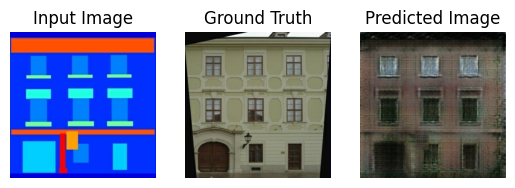

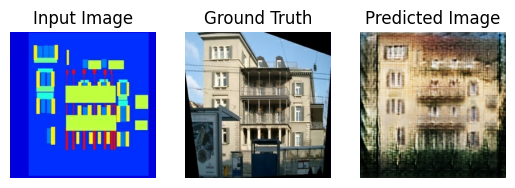

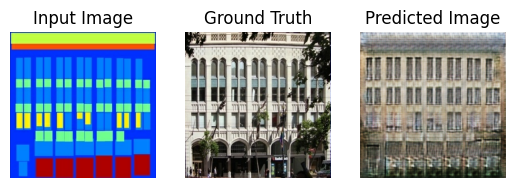

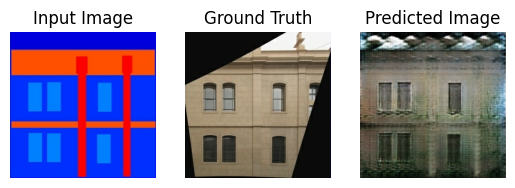

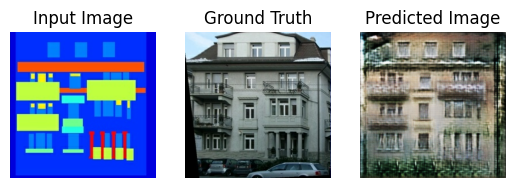

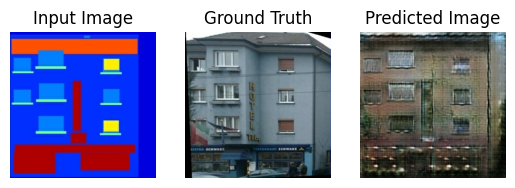

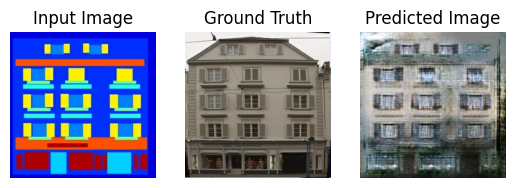

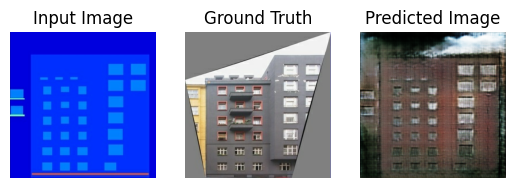

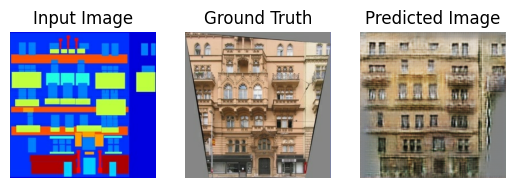

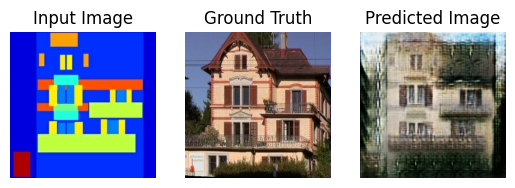

In [143]:
for example_input, example_target in test_ds.take(1):
     gen_pred = model.generator_model.predict(example_input)

for i in range(10): 
    plt.figure()
    display_list = [example_input[i], example_target[i], gen_pred[i]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()